In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
tf.keras.backend.set_session(session)

In [5]:
# Allow loading crc_ml scripts as modules
import sys
from pathlib import Path
module_path = Path('.').resolve().parent
if str(module_path) not in sys.path:
    sys.path.append(str(module_path))

In [2]:
from src.config import SLIDE_DIR

In [3]:
from src.datagens import DataSource
ds = DataSource()
ds.add_dataset('/mnt/data/crc_ml/data/processed/Prostata/level1/context3/t96px/all/datasets/prospective.h5', 'train')
train_ds, valid_ds = ds.split(0.05)

test_ds = DataSource()
test_ds.add_dataset('/mnt/data/crc_ml/data/processed/Prostata/level1/context3/t96px/all/datasets/prospective.h5', 'test')

In [4]:
import json
with open('/mnt/data/crc_ml/configs/wsi.json', 'r') as jin:
    config = json.load(jin)
config['data']['meta']['context_size'] = 3
config

{'train': {'workers': 2,
  'validation_steps': 2000,
  'epochs': 2,
  'train_augment_type': None,
  'use_multiprocessing': False,
  'valid_augment_type': None,
  'valid_generator_type': 'linear',
  'max_queue_size': 5,
  'steps_per_epoch': 10000,
  'sampling_ratio': [0.2, 0.8]},
 'model': {'l1_reg': None,
  'l2_reg': None,
  'input_shape': [96, 96, 3],
  'dropout': 0.5,
  'trainable': True,
  'output_size': 1,
  'learning_rate': 0.0005,
  'checkpoint': None},
 'batch_size': 16,
 'callbacks': {'reduce_lr_on_plateau': {'monitor': 'val_f1',
   'factor': 0.5,
   'min_lr': 1e-07,
   'mode': 'max',
   'patience': 2},
  'early_stopping': {'monitor': 'val_f1',
   'patience': 5,
   'mode': 'max',
   'restore_best_weights': True}},
 'data': {'meta': {'level': 1, 'tile_size': 96, 'context_size': 3},
  'augmenters': {'horizontal': 0.5,
   'vertical': 0.5,
   'brightness': [-64, 64],
   'hue': [-10, 10],
   'saturation': [-64, 64],
   'contrast': [0.5, 2.0]},
  'dataset': None},
 'test': {'workers'

In [5]:
from src.datagens import WSIDatagen
dg = WSIDatagen(config, SLIDE_DIR)
train_gen, valid_gen = dg.get_training_generator(train_ds, valid_ds)
test_gen = dg.get_sequential_generator(test_ds)

In [10]:
X,y = train_gen[20]

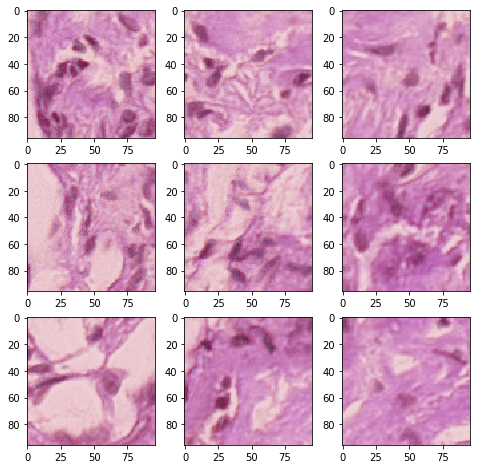

In [11]:
w=10
h=10
c = 3
fig=plt.figure(figsize=(8, 8))
for i in range(1, c*c+1):
    img = ((X[0][i-1] + 1) * 127.5).astype(np.uint8)
    fig.add_subplot(c, c, i)
    plt.imshow(img)
plt.show()

In [24]:
with open('/mnt/data/crc_ml/configs/wsi.json') as f_config:
    config = json.load(f_config)
#config['model']['checkpoint'] = '/mnt/data/crc_ml/models/checkpoints/GLADOS-CHCK-3544-42e6-b1c2-e6e6eed83b2b/early.hdf5'
config['data']['meta']['context_size'] = 3
config['model']['learning_rate'] = 0.00005
config['model']['dropout'] = 0.10
config['model']['input_shape'] = tuple(config['model']['input_shape'])
config

{'train': {'workers': 2,
  'validation_steps': 2000,
  'epochs': 2,
  'train_augment_type': None,
  'use_multiprocessing': False,
  'valid_augment_type': None,
  'valid_generator_type': 'linear',
  'max_queue_size': 5,
  'steps_per_epoch': 10000,
  'sampling_ratio': [0.2, 0.8]},
 'model': {'l1_reg': None,
  'l2_reg': None,
  'input_shape': (96, 96, 3),
  'dropout': 0.1,
  'trainable': True,
  'output_size': 1,
  'learning_rate': 5e-05,
  'checkpoint': None},
 'batch_size': 16,
 'callbacks': {'reduce_lr_on_plateau': {'monitor': 'val_f1',
   'factor': 0.5,
   'min_lr': 1e-07,
   'mode': 'max',
   'patience': 2},
  'early_stopping': {'monitor': 'val_f1',
   'patience': 5,
   'mode': 'max',
   'restore_best_weights': True}},
 'data': {'meta': {'level': 1, 'tile_size': 96, 'context_size': 3},
  'augmenters': {'horizontal': 0.5,
   'vertical': 0.5,
   'brightness': [-64, 64],
   'hue': [-10, 10],
   'saturation': [-64, 64],
   'contrast': [0.5, 2.0]},
  'dataset': None},
 'test': {'workers':

In [21]:
model.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 9, 96, 96, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 96, 96, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
NASNet (Model)                  (None, 3, 3, 1056)   4269716     lambda[0][0]                     
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1056)         0           NASNet[1][0]                     
__________________________________________________________________________________________________
global_max

In [ ]:
model.model.fit_generator(generator=train_gen, validation_data=valid_gen, epochs=1, verbose=1, 
                          max_queue_size=5, workers=2, use_multiprocessing=False)

In [ ]:
model.model.predict_on_batch(valid_gen[0])

array([1, 1, 1, 0, 1, 1, 0, 0])

In [22]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.applications import NASNetMobile as NASNet

class Model:
    def __init__(self, name, config):
        self.name = name
        self.config = config
        self.regularizer = self.get_regularizer(config['model']['l1_reg'], config['model']['l2_reg'])

    def get_regularizer(self, l1_reg, l2_reg):
        if l1_reg is not None and l2_reg is not None:
            log.info('Applying l1_l2 regularizer.')
            return l1_l2(l1=l1_reg, l2=l2_reg)
        elif l1_reg is not None:
            log.info('Applying l1 regularizer.')
            return l1(l1_reg)
        elif l2_reg is not None:
            log.info('Applying l2 regularizer.')
            return l2(l2_reg)
        else:
            return None

    def load_weights(self, ckpt):
        if ckpt is not None:
            self.model.load_weights(str(ckpt))

    def compile_model(self):
        metrics=[BinaryAccuracy(), Precision(), Recall()]
        self.model.compile(loss='binary_crossentropy' , metrics=metrics, optimizer=Adam(lr=self.config['model']['learning_rate']))
        
class BatchContextNASNetModel(Model):

    def __init__(self, config):
        super().__init__('BatchContextNASNetMobile', config)
        self.context_size = self.config['data']['meta']['context_size']
        self.model = self._build_model()
        self.load_weights(config['model']['checkpoint'])

    def _build_model(self):
        inp = Input((self.context_size*self.context_size,) + self.config['model']['input_shape'])
        out = Lambda(lambda x: tf.keras.backend.reshape(x, (-1,) + self.config['model']['input_shape']))(inp)

        nasnet = tf.keras.applications.nasnet.NASNetMobile(weights='imagenet', input_tensor=out, include_top=False)
        nasnet.trainable=self.config['model']['trainable']

        out = nasnet(out)
        out_1 = GlobalAveragePooling2D()(out)
        out_1 = Dense(256, 'relu', name='GAP2D_Dense')(out_1)

        out_2 = GlobalMaxPooling2D()(out)
        out_2 = Dense(256, 'relu', name='GMP2D_Dense')(out_2)

        out_3 = Flatten()(out)
        out_3 = Dense(512, 'relu', name='Flatten_Dense')(out_3)

        out = Concatenate()([out_1, out_2, out_3])
        out = Lambda(lambda x: tf.keras.backend.reshape(x, (-1, self.context_size*self.context_size*1024)), name='Unpack_Layer')(out)

        #out = Dense(self.config['model']['output_size'], 'sigmoid', name='Output_Dense')(out)
        m = tf.keras.Model(inp, out)
        return m

In [25]:
model = BatchContextNASNetModel(config)

In [32]:
dummy_input = np.random.random((8,9,96,96,3))

In [34]:
res = model.model.predict(dummy_input)
print(res.shape)

(8, 9216)
